In [1]:
#do this later from admin: !python -m pip install --upgrade pip


# TOC

0. [Imports](#first-bullet)
1. [EDA](#1.0-bullet)
2. [Feature Engineering](#2.0-bullet)  
 2.1 [Pt 1 - Regression](#2.1-bullet)  
 2.2 [Pt 2 - Classification](#2.2-bullet)
3. [Basic Model](#3.0-bullet)  
 3.1 [Pt 1 - Regression](#3.1-bullet)  
 3.2 [Pt 2 - Classification](#3.2-bullet)
4. [Reference and Planning](#4.0-bullet)

Date Time
* General: publishedAt
* Friday (is_friday)
* Is weekend (is_weekend)
* week number (week)
* Month day (month_day)
* Month (month)
* 2 digit year number (year)

* Ignoring overall day count - possible overfit to search algorithm

Description
* Sentiment (description_sentiment)
* Overall word count (description_wordcount)
* CVEC (./data/engineered_data/description_wordvec.csv)


Tags
* Sentiment (tags_sentiment)
* Num tags (tags_wordcount)
* CVEC (./data/engineered_data/tag_wordvec.csv)

Title
* Sentiment (title_sentiment)
* Word count (title_wordcount)
* feat / ft. (title_featuring)
* Letter Count (intitle_ + a,b,c,...)
* String length (title_length)
* Which letters
* Length  
* CVEC (./data/engineered_data/title_wordvec.csv)

Ratios
* likes / views (lv_ratio)
* comments / view (comment_view_ratio)
* likes / dislikes (like_dislike_ratio)

Measures (includes log)
  * commentCount
  * dislikeCount 
  * favoriteCount 
  * likeCount: 
  * viewCount: view_log

Other
* Has content rating restriction (contentRating)
* Has any region Restriction (regionRestriction)
* Has captioned text (caption)
* Content has approved license (licensedContent)
* Duration of video (duration)
* High definition 1 or std (0) (definition)


In [1]:
#Basic
import pandas as pd
import numpy as np
#Math
import scipy as sp
from random import randint
from math import exp
import operator

#Scraping
import requests
import json

#Youtube Data API Packages: 
"""from apiclient.discovery import build
from apiclient.errors import HttpError
from oauth2client.tools import argparser
from googleapiclient.discovery import build
import argparse
from googleapiclient.errors import HttpError"""

#Modeling
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN, KMeans
from sklearn.svm import SVC
from sklearn.metrics import r2_score,confusion_matrix, roc_auc_score, roc_curve, silhouette_score

#NLP & Text Management
# from sklearn.feature_extraction import stop_words
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# import re
# from textblob import TextBlob
# from wordcloud import WordCloud
# from nltk.stem import PorterStemmer

#Time analysis
import time
import datetime
# from statsmodels.tsa.stattools import pacf
# from statsmodels.graphics.tsaplots import plot_pacf

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud

%matplotlib inline
plt.style.use('classic')
sns.set_style('whitegrid')

In [2]:
df_main = pd.read_csv('./data/engineered_data/data_engineered_10.9_2019.csv')

In [3]:
model_time = ['is_weekend', 'is_friday', 'year_day', 'week', 'week_day', 'month', 'month_day', 'year',  ]
model_text = ['description_sentiment', 'description_wordcount',
  'tags_sentiment', 'tags_wordcount', 'title_sentiment',
 'title_wordcount', 'title_featuring', 'title_length', ]
model_title_letter = ['intitle_a',  'intitle_b', 'intitle_c', 'intitle_d', 'intitle_e', 'intitle_f', 'intitle_g',
 'intitle_h', 'intitle_i', 'intitle_j', 'intitle_k', 'intitle_l', 'intitle_m', 'intitle_n', 'intitle_o',
 'intitle_p', 'intitle_q', 'intitle_r', 'intitle_s', 'intitle_t', 'intitle_u', 'intitle_v', 'intitle_w',
 'intitle_x', 'intitle_y', 'intitle_z',]              
model_ratios = ['lv_ratio', 'comment_view_ratio', 'like_dislike_ratio',]
model_other = ['duration', 'contentRating', 'regionRestriction',  'licensedContent', 'caption', 'definition']
measures = ['likeCount', 'dislikeCount', 'commentCount', 'viewCount',
            'view_log',  'comment_log',  'like_log', 'dislike_log', 
            'view_class' ]
non_model_cols = ['request_token', 'letter_search','channelTitle', 'tags', 'title', 'vidId','publishedAt','favoriteCount',
              'description','defaultLanguage', ]

# <a class="anchor" id="3.0-bullet"> 3. Basic Model</a>

In [5]:
def get_model_data(exclude_ratios=True, additional_cols_exclude=None, include_text_vecs=False, 
                   additional_cols_include=None, data=df_main):
    data=data
    if include_text_vecs:
        df_description = pd.read_csv('./data/engineered_data/description_wordvec.csv')
        df_tag = pd.read_csv('./data/engineered_data/tag_wordvec.csv')
        df_title = pd.read_csv('./data/engineered_data/title_wordvec.csv')
        df_combined = df_description.join(df_tag.set_index('vidId'), on=df_description['vidId'], how='left', rsuffix='tag')
        df_combined = df_combined.join(df_title.set_index('vidId'), on=df_combined['vidId'], how='left', rsuffix='title')

        cols_exclude_text = [col for col in df_combined.columns if '_word_' not in str(col)]
        cols_include_initial_text = [col for col in df_combined.columns if col not in cols_exclude]

        df_formodel = data.join(df_combined.set_index('vidId'), on=data['vidId'], how='left', rsuffix='text_combo')

    else:
        df_formodel = data
        
    cols_alphabet = ['intitle_a', 'intitle_d', 'intitle_f', 'intitle_g', 'intitle_i', 
                     'intitle_k', 'intitle_l','intitle_p','intitle_v','intitle_x','intitle_y' ]
    
    cols_exclude = ['vidId', 'year_day', 'month', 'tags_sentiment','title_sentiment', 'title_wordcount' ,
                    'titletext_combo', 'tagstext_combo', 'descriptiontext_combo', 'description', 'tags', 'title', 'view_log', 
                   'view_logtitle', 'view_logtag', 'Unnamed: 0title', 'Unnamed: 0']
    #
    
    if exclude_ratios:
        cols_exclude += ['lv_ratio', 'comment_view_ratio', 'like_dislike_ratio']
    if additional_cols_exclude!=None:
        cols_exclude+=additional_cols_exclude

    cols_include = [col for col in df_formodel.columns if \
    (col in model_time or \
    col in model_text or \
    col in cols_alphabet or \
    col in model_ratios or \
    col in model_other ) and \
    col not in cols_exclude]
    
    if additional_cols_include!=None:
        cols_include+=additional_cols_include

    df_formodel = df_formodel[df_formodel['view_class']>1]     
        
    y = df_formodel.view_log
    X = df_formodel.loc[:, cols_include]
    X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=30)

    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    
    return X_train_sc, X_test_sc, y_train, y_test, ss, df_formodel, cols_include

## <a class="anchor" id="3.1-bullet">3.1 Unsupervised Learning</a>



### KMeans

In [93]:
X_train_sc, X_test_sc, y_train, y_test, ss, df_formodel, cols_include = get_model_data(
    additional_cols_exclude=list(df_main.columns),
    additional_cols_include=['tags_sentiment', 'description_sentiment', 
                             'description_wordcount', 'title_featuring','duration', 
                             'year',  'title_length','lv_ratio',  ], exclude_ratios=True)

#'intitle_i','caption','year_day','view_log',
uns_ss = StandardScaler()
uns_X_sc = uns_ss.fit_transform(df_formodel.loc[:, cols_include])

In [95]:
for n in range(10, 20):
    classifier = KMeans(n_clusters=n,random_state=42)
    classifier.fit(X=uns_X_sc)
    print('   n: {}, inertia: {}, silhouette: {}'.format(n, classifier.inertia_, silhouette_score(uns_X_sc,classifier.predict(X=uns_X_sc))))
#213447

   n: 10, inertia: 29090.24836681549, silhouette: 0.21068012820798745
   n: 11, inertia: 27970.073955577027, silhouette: 0.20902584404764926
   n: 12, inertia: 27340.393670744226, silhouette: 0.1865013130774859
   n: 13, inertia: 26489.57970804651, silhouette: 0.20333173784067374
   n: 14, inertia: 25613.83651674319, silhouette: 0.19080513369091626
   n: 15, inertia: 24973.79620341238, silhouette: 0.18582266290966726
   n: 16, inertia: 24411.063442250586, silhouette: 0.18785847956342208
   n: 17, inertia: 23606.788746240265, silhouette: 0.18685290920586212
   n: 18, inertia: 23232.72935669079, silhouette: 0.17561587531730566
   n: 19, inertia: 22536.693620685728, silhouette: 0.18872028305769137


In [96]:
classifier = KMeans(n_clusters=13, random_state=42)
classifier.fit(uns_X_sc)
k_preds = classifier.predict(uns_X_sc)

In [97]:
df_classified = df_formodel

df_classified = df_classified.fillna('')

df_classified['kclass'] = k_preds

df_classified[df_classified.title.str.contains('Despacito')].loc[:, ['title', 'viewCount', 'kclass']]

,title,viewCount,kclass
3270,Luis Fonsi - Despacito ( cover by J.Fla ),127411039,6
7479,Luis Fonsi - Despacito ft. Daddy Yankee,5555912002,2
7594,"Luis Fonsi, Daddy Yankee - Despacito (Remix Au...",633857377,2


In [98]:
for i in range(9):
     print('   ', i, df_classified[df_classified.kclass==i].shape[0])

    0 1057
    1 547
    2 1051
    3 1521
    4 612
    5 712
    6 1489
    7 15
    8 228


In [111]:
#

In [121]:
df_classified.loc[:, cols_include+['kclass', 'view_log']].groupby(by='kclass').mean()

,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio,view_log
kclass,,,,,,,,,
0,0.051768,0.126262,77.724693,0.000000,548.954588,15.742668,74.550615,0.656672,6.132975
1,0.042875,0.114358,298.504570,0.000000,379.054845,14.153565,43.672761,0.676074,6.843515
2,0.060699,0.170634,76.170314,1.000000,272.070409,15.022835,55.864891,0.693053,6.926276
3,0.010988,0.042734,41.035503,0.000000,348.441157,9.702827,36.304405,0.632759,6.619539
4,0.495315,0.268195,84.192810,0.024510,398.790850,14.168301,45.176471,0.666854,6.560195
5,0.050492,0.549484,53.226124,0.026685,339.589888,13.248596,37.203652,0.669617,6.768120
6,0.007018,0.058260,48.310275,0.000000,320.813298,16.721289,36.192075,0.694664,6.288292
7,0.031389,0.095691,130.866667,0.000000,22467.133333,16.133333,76.000000,0.592682,5.525531
8,-0.325323,-0.370506,80.820175,0.144737,315.065789,15.978070,50.929825,0.692509,6.738894


In [181]:
kclass_iloc = len(df_classified.columns)-1

In [131]:
cluster_centers = pd.DataFrame(classifier.cluster_centers_, columns=cols_include)
cluster_centers

,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio
0,-0.032081,-0.021104,-0.119356,-0.404976,0.009436,0.461377,1.374793,0.176672
1,-0.077752,-0.071163,1.623494,-0.404976,-0.111133,-0.005258,-0.181715,0.319037
2,0.014085,0.162172,-0.131347,2.469283,-0.187041,0.249727,0.433154,0.443642
3,-0.241526,-0.372364,-0.408983,-0.404976,-0.132858,-1.312204,-0.553143,0.001201
4,2.245971,0.575770,-0.068297,-0.334528,-0.097127,-0.000931,-0.105915,0.251380
5,-0.038890,1.763138,-0.312750,-0.324238,-0.139164,-0.269763,-0.506256,0.271384
6,-0.261819,-0.306545,-0.351605,-0.404976,-0.152485,0.748013,-0.559083,0.455562
7,-0.136747,-0.149662,0.300150,-0.404976,15.563669,0.576095,1.447854,-0.292875
8,-1.968812,-2.110165,-0.094920,0.011035,-0.156543,0.530502,0.184103,0.439638
9,0.147110,0.102152,0.408928,-0.404976,4.106795,0.450957,0.881663,-0.250424


In [187]:
sum((uns_X_sc[1]-np.array(cluster_centers.iloc[k_preds[1], :]))**2)**.5

1.4037509081714712

In [188]:
class_dist = []
for i in range(df_classified.shape[0]):
    class_dist.append(sum((uns_X_sc[i]-np.array(cluster_centers.iloc[k_preds[i], :]))**2)**.5)

In [191]:
df_classified['dist_to_center'] = class_dist

In [199]:
df_classified[df_classified.kclass==0].loc[:, ['title', 'description', 'view_log','vidId', 'dist_to_center']+cols_include].sort_values(by='dist_to_center').head(10)

,title,description,view_log,vidId,dist_to_center,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio
2275,"Mikhail Glinka - Nocturne in F minor ""La separ...",Mikhail Ivanovich Glinka (1 June [O.S. 20 May]...,5.334795,8g7_HR_2A0s,0.472424,0.000000,0.168750,91,0,237,15,74,0.641590
7936,อาจเป็นเพราะ (Because of you) - Ploychompoo (J...,“อาจเป็นเพราะ (Because of you)” \r\r\r\nเพลงขอ...,7.423960,kafNi1pTSB8,0.510444,0.000000,0.125000,81,0,399,16,69,0.698420
8588,Pablopavo \ Iwanek \ Praczas \ Październikowy...,Przedsprzedaż: http://www.karrot.pl/wir\r\r\r\...,5.964908,z-XZUh1dUWE,0.603429,0.000000,0.100000,102,0,264,15,69,0.618666
2231,JEFF THE KILLER VS. JASON VOORHEES ║ COMBATES ...,Esta es la SEGUNDA PARTE del Especial de Hallo...,7.269833,8IyWmsKrw1A,0.619989,0.000000,0.144444,100,0,201,15,69,0.697581
7942,Dawna pieśń sławiańska w jęz. polskim (Ancient...,Pieśń pochodzi z płyty Orkiestry św. Mikołaja ...,6.116781,tDQActClEBQ,0.635752,0.000000,0.000000,93,0,458,16,72,0.642633
3144,Ceylin-H | Abdest Şarkısı - Abdest almayı öğre...,Çocukların abdest almayı eğlenceli bir şekilde...,7.034295,aKLYR8FrTTY,0.653124,0.000000,0.100000,93,0,180,16,67,0.611471
4781,Lisa Angell - N'oubliez Pas (France) - LIVE at...,Live performance in the second Grand Final of ...,6.229165,tJful-Jtc9o,0.669959,0.000000,0.159091,20,0,190,15,74,0.630026
8427,Alicia Keys & Jay Z - Empire State of Mind LIV...,High quality video of Alicia Keys & Jay Z perf...,7.163640,1TC02VaB1Rw,0.674397,0.136364,0.148182,25,0,335,16,75,0.688641
8231,"Joaquín Sabina, Mara Barros - Y Sin Embargo Te...",Joaquín Sabina interpretendo 'Y Sin Embargo Te...,7.413006,rVmiP7fF71A,0.675985,0.000000,0.000000,79,0,644,15,79,0.662485
5934,Dave East x Don Q x Fabolous x Juelz Santana T...,Purchase Link (Instant Delivery): https://bsta...,5.973040,uurbXbAj0mk,0.695448,0.000000,0.045455,64,0,225,17,72,0.695228


In [200]:
df_classified[df_classified.kclass==1].loc[:, ['title', 'description', 'view_log','vidId', 'dist_to_center']+cols_include].sort_values(by='dist_to_center').head(10)

,title,description,view_log,vidId,dist_to_center,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio
1945,F.Charm – Cod rosu (by Lanoy) [Videoclip oficial],Nu uita sa te abonezi: http://bit.ly/1TnAS3m\r...,7.186594,DP5BFH3QDjs,0.413902,0.000000,0.130000,287,0,254,14,49,0.653178
6976,OK Go - I Won't Let You Down - Official Video,Website | www.okgo.net\r\r\r\nInstagram | www....,7.596648,u1ZB_rGFyeU,0.430592,0.047222,0.147947,304,0,321,14,45,0.729705
6936,Don't Cry For Me Argentina - Madonna,Don't Cry For Me Argentina - Madonna\r\r\r\nMu...,7.296915,MEMUsC8ppU0,0.567197,0.000000,0.132461,323,0,335,15,36,0.657951
767,C-BooL - Never Go Away (Official Video),C-BooL Instagram: https://www.instagram.com/c_...,7.682601,dqVZaN4lnwQ,0.698618,0.021645,0.143878,336,0,230,16,39,0.691312
1638,Reginaldo Rossi - A Raposa e as Uvas,Reginaldo Rossi - A Raposa e as Uvas\r\r\r\nDV...,7.196686,ZilzHlaaw0U,0.717448,0.000000,0.000000,263,0,287,14,36,0.679171
103,David Bowie – Space Oddity (Official Video),Official video for Space Oddity by David Bowie...,7.448142,iYYRH4apXDo,0.726023,0.062500,0.092795,225,0,305,15,43,0.720516
1981,4 Walls (English Original Demo) - f(x) ~ LYRICS,"writers/singers: Tay Jasper, Adrian\r\r\r\npro...",6.138083,vFuU4rIZZ30,0.736557,0.000000,0.029055,305,0,207,15,47,0.745281
8626,Pezet & Czarny HIFI - Co jest ze mną nie tak,http://www.facebook.com/kokabeats\r\r\r\nhttp:...,7.033855,jp_XgZIaopk,0.772147,0.000000,0.000000,294,0,212,16,44,0.687371
4251,Meghan Trainor - All About That Bass,Meghan Trainor's official music video for 'All...,9.347733,7PCkvCPvDXk,0.799419,0.002525,0.101257,233,0,190,14,36,0.729913
2069,SPT - Everybody Knows Sh*t's F*cked (REDDIT Ed...,"Please watch: ""Everybody Knows Sh*t's F*cked O...",6.431700,NWxISwEBU0U,0.808098,0.136364,0.115189,298,0,166,14,52,0.740191


In [201]:
df_classified[df_classified.kclass==2].loc[:, ['title', 'description', 'view_log','vidId', 'dist_to_center']+cols_include].sort_values(by='dist_to_center').head(10)

,title,description,view_log,vidId,dist_to_center,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio
8203,"Enrique Iglesias - Noche Y De Dia ft. Yandel, ...",NEW SONG - MOVE TO MIAMI feat. Pitbull (Click ...,8.139405,m3We7p78XTo,0.352662,0.000000,0.203523,79,1,284,15,56,0.703870
7521,Ricky Martin - Vente Pa' Ca (Official Video) f...,"Ricky Martin feat. Maluma - ""Vente Pa' Ca"" (Of...",9.158901,iOe6dI2JhgU,0.425306,0.011688,0.200000,86,1,289,16,55,0.707186
3333,J-AX feat. IL CILE - MARIA SALVADOR (OFFICIAL ...,"J-AX FEAT. IL CILE: ""MARIA SALVADOR"" VIDEO UFF...",8.190438,Yrtpl9aDDrk,0.430333,0.000000,0.125000,62,1,236,15,52,0.697173
2569,G-Eazy - Some Kind Of Drug (Audio) ft. Marc E....,"G-Eazy new album ""When It's Dark Out"" Availabl...",7.546406,Cm9hFuxMuac,0.439606,0.090057,0.162121,35,1,225,15,52,0.714395
7719,Banky W - Unborn Child feat. Lynxxx (Official ...,"The music film for Banky W's ""Unborn Child"" (f...",5.771304,FjlEAKLl-Zs,0.497926,0.000000,0.188961,104,1,412,15,57,0.653837
224,"Freak - Steve Aoki, Diplo, & Deorro (ft. Steve...",Vote for Steve Aoki for DJ Mag Top 100: http:/...,6.934870,VbCxwQud4sM,0.527401,0.021433,0.241253,89,1,290,14,52,0.705771
8608,"Big Sean - Blessings (Explicit) ft. Drake, Kan...",D A R K S K Y P A R A D I S E\r\r\r\nAVAILAB...,8.353893,M6t47RI4bns,0.545959,0.000000,0.248148,79,1,312,15,53,0.729111
4751,Snoop Dogg - Peaches N Cream ft. Charlie Wilson,"""Peaches N Cream"" taken from Snoop Dogg's new ...",7.170031,1UAIxwYEgm0,0.589877,0.000000,0.136364,55,1,260,15,47,0.700113
4304,Meghan Trainor - Like I'm Gonna Lose You ft. J...,"Download ""Title"" at iTunes: http://smarturl.it...",8.697509,2-MBfn8XjIU,0.607533,0.075714,0.100000,27,1,228,15,56,0.741234
2016,Young F ft Jeivy Dance - Que Me Vaya [Masteriz...,"Music video by Young F ""El Prefe"" © 2016 by Yo...",6.899258,iy26i11RK3c,0.609093,0.100000,0.112500,32,1,240,15,58,0.642363


In [212]:
df_classified[df_classified.title.str.contains('Luis Fonsi - Despacito ft. Daddy Yankee')].loc[:, ['title', 'description', 'view_log','vidId', 'dist_to_center']+cols_include].sort_values(by='dist_to_center').head(10)

,title,description,view_log,vidId,dist_to_center,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio
7479,Luis Fonsi - Despacito ft. Daddy Yankee,“Despacito” disponible ya en todas las platafo...,9.744755,kJQP7kiw5Fk,1.986066,0.333333,0.0,33,1,282,17,39,0.767382


In [202]:
df_classified[df_classified.kclass==3].loc[:, ['title', 'description', 'view_log','vidId', 'dist_to_center']+cols_include].sort_values(by='dist_to_center').head(10)

,title,description,view_log,vidId,dist_to_center,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio
1209,Ray Charles - What'd I Say Pts. 1 & 2,Ray Charles - What'd I Say Pts. 1 & 2 from the...,6.567074,xTIP_FOdq24,0.260634,0.0,0.0000,34,0,389,10,37,0.651883
1361,"Quelques mots d'amour, Michel Berger","Michel Berger, pseudonyme de Michel Jean Hambu...",6.775274,Q-0mLKNhFX0,0.314891,0.0,0.0000,31,0,218,10,36,0.605171
2400,"バッハ「G線上のアリア」 Bach ""Air on G String""",ヨハン・セバスチャン・バッハ作曲「管弦楽組曲第3番BWV1068」\r\r\r\r\nJoh...,7.149969,thQWqRDZj7E,0.318867,0.0,0.0625,16,0,332,10,35,0.605350
3966,Tutto L'Amore Che Ho - Video Ufficiale,Produced by Paolo Soravia\r\r\r\r\nDirector Ma...,7.382998,D3HwnYbU_1A,0.355186,0.0,0.0000,12,0,257,10,38,0.651548
3967,Francesco Guccini - L' Avvelenata,"La cantavo che non avevo neanche 18 anni, ora ...",6.706417,zXwZrlGxaXc,0.355720,0.0,0.0000,15,0,282,10,33,0.618316
5842,Juan Gabriel Ya lo se que tu te vas,Un canto a un amor que se nos va..! Todo un ex...,7.710169,TPRXDLfzkeg,0.359399,0.0,0.0000,21,0,223,10,36,0.664103
5115,MARISELA O ME QUIERES O ME DEJAS,"PRESENTACION EN ""SIEMPRE EN DOMINGO"", 1989",7.196435,idk9tZcwACQ,0.370241,0.0,0.0000,5,0,204,10,37,0.627798
5303,Ska-P - Sexo Y Religion (Videoclip),Music video by Ska-P performing Sexo Y Religio...,6.888444,3qOP81-RO5c,0.374306,0.0,0.0000,11,0,305,9,35,0.629593
4979,Sinead O'Connor - This is a Rebel Song,From PBS Sessions at West 54th,6.578856,wbre5Fs9m8I,0.376721,0.0,0.0000,5,0,207,10,38,0.629647
8290,Jorge Drexler - La trama y el desenlace,© 2010 WMG\r\r\r\nLa trama y el desenlace,6.981255,QgZBKNdo8gs,0.380601,0.0,0.0000,6,0,233,10,39,0.634080


In [203]:
df_classified[df_classified.kclass==4].loc[:, ['title', 'description', 'view_log','vidId', 'dist_to_center']+cols_include].sort_values(by='dist_to_center').head(10)

,title,description,view_log,vidId,dist_to_center,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio
3572,K. Michelle - Love 'Em All (Official Music Video),"Pre-order K. Michelle's ""Anybody Wanna Buy A H...",7.551626,BMTEqvYBbMc,0.565222,0.500000,0.321429,47,0,257,14,49,0.715592
1380,D'Angelo and The Vanguard - Really Love (Audio),New album BLACK MESSIAH out now! iTunes: http:...,6.805809,mVsQwJfWzoI,0.697800,0.500000,0.142677,31,0,347,14,47,0.683092
7536,Flashmob Nürnberg 2014 - Ode an die Freude,http://www.evenordbank.de/\r\r\r\nAus Wertschä...,7.054517,a23945btJYw,0.888085,0.400000,0.285156,170,0,392,14,42,0.697951
1099,Nelly - Just A Dream (Dion C Bootleg) 👑 Rex So...,☆Rex Sounds. We love music.☆\r\r\r\nDo you lov...,7.492331,0bJQ2guNEsU,0.888609,0.522222,0.442208,50,0,302,15,50,0.691880
4808,Galantis & Hook N Sling - Love On Me (Official...,Galantis & Hook N Sling - Love On Me (Official...,7.472692,8gz9NsNH96Q,0.888986,0.436301,0.216688,86,0,213,16,53,0.725331
1584,E-girls / Love ☆ Queen (Music Video) ～歌詞有り～,過去最大規模！E-girls史上初のアメリカ ラスベガスでの撮影となる超大作！\r\r\r\...,6.884741,zo2YakKCwIk,0.918009,0.440000,0.257576,60,0,250,17,43,0.658247
6883,Journey - Don't Stop Believin' (Audio),Journey's official audio for 'Don't Stop Belie...,7.548646,1k8craCGpgs,0.924454,0.625000,0.230952,104,0,251,13,38,0.709401
5056,Karaoke Sweet Child O'Mine - Guns N' Roses *,Download MP3: http://www.karaoke-version.com/m...,6.924501,uhiamj_I7II,0.944272,0.350000,0.337500,92,0,364,13,44,0.619820
5864,"Mick Jenkins - ""P's & Q's"" (Official Music Video)","""Wave[s]"" available now!\r\r\r\niTunes: http:/...",6.342241,GigIohlYqEI,0.945235,0.400000,0.400000,33,0,158,15,49,0.698028
4851,Guns N' Roses - Sweet Child O' Mine (Live),Available Now. Get Yours Today! \r\r\r\n- ...,6.912033,1lKp5t1bYXs,0.945468,0.350000,0.397273,93,0,344,14,42,0.674144


In [204]:
df_classified[df_classified.kclass==5].loc[:, ['title', 'description', 'view_log','vidId', 'dist_to_center']+cols_include].sort_values(by='dist_to_center').head(10)

,title,description,view_log,vidId,dist_to_center,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio
818,C-Kan - Voy Por El Sueno de Muchos,"From the album, ""Voy Por el Sueno de Muchos"" A...",7.520136,lxNGM50_688,0.427666,0.000000,0.500000,34,0,333,13,34,0.682457
5610,Ed Sheeran - Thinking Out Loud [Official],Official audio of one of my favourites from th...,7.530840,WpyfrixXBqU,0.485984,0.098295,0.515152,76,0,293,14,41,0.692995
7993,Lead Me Lord - Gary Valenciano (w/ lyrics),My creative way of sharing my love for Jesus a...,7.351350,76KsgvKrqnI,0.497080,0.060000,0.525000,47,0,255,12,42,0.646956
772,C-Kan - La Calle Sabe De Mi Nombre,"From the album, ""Clasificacion C, Vol. 1"". Av...",7.832833,Jm_ZdGh55n4,0.527578,0.000000,0.500000,30,0,221,14,34,0.698199
7893,Michael W. Smith - Sovereign Over Us (Live),This song is from the new album SOVEREIGN.\r\r...,6.282113,4x8TZiwPGa0,0.530915,0.000000,0.568182,49,0,370,14,43,0.633899
6755,PSY - Performs on 'The X-Factor Australia',PSY visited 'The X-Factor Australia' performe...,7.336306,t7haawDNiNw,0.563703,0.000000,0.500000,52,0,433,12,42,0.674697
4786,"X Ambassadors, Jamie N Commons - Jungle","Get X Ambassadors’ debut album, VHS, out now: ...",7.234503,aqXW57WM9TA,0.567530,0.000000,0.500000,51,0,197,14,39,0.719961
6614,X Ambassadors - Unconsolable,"Get X Ambassadors’ debut album, VHS, out now: ...",6.945589,EzP5KsYSGD0,0.568902,0.000000,0.525000,62,0,219,13,28,0.678365
2025,\/\/σrds - ℱ.ℛ Ɗavid | Full HD |,F. R David - Words\r\r\r\nSee More On https://...,6.488337,_MdNXV0yfsA,0.569531,0.000000,0.500000,11,0,206,13,32,0.655737
8683,OneRepublic - Something I Need,"Get OneRepublic’s new single, ‘Wherever I Go,’...",7.705349,qKCGBgOgp08,0.571000,0.000000,0.512987,43,0,250,13,30,0.707738


In [205]:
df_classified[df_classified.kclass==6].loc[:, ['title', 'description', 'view_log','vidId', 'dist_to_center']+cols_include].sort_values(by='dist_to_center').head(10)

,title,description,view_log,vidId,dist_to_center,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio
3933,G Herbo - L's (Official Music Video),"The official music video of G Herbo's ""L's"". \...",6.944571,CkLPal4qt50,0.274430,0.0,0.050000,48,0,243,16,36,0.673102
3894,กอดจูบลูบคลำ L.กฮ. | TMG OFFICIAL MV,เพลงยอดฮิตของ วง L.กฮ. ที่ฟังแล้วคุณจะไม่มีวั...,8.431283,Wx1jNRHoKyo,0.294646,0.0,0.000000,47,0,203,17,36,0.680240
4111,Jok´air - L'etrangere | A COLORS SHOW,French rapper Jok’air effortlessly merges the ...,6.408118,zTG3BrJqXrs,0.338854,0.0,0.107143,39,0,246,17,37,0.726571
4958,Damares - Sou o Que Sou (Videoclipe),"Vídeo Oficial de ""Sou o Que Sou"" de Damares.\r...",6.493356,8uRXw8pYCbM,0.339832,0.0,0.000000,21,0,324,17,36,0.697803
4598,Rag'n'Bone Man - Grace (Official Audio),Taken from Rag'n'Bone Man's debut album 'Human...,6.963270,SCnsEy0tpbw,0.341302,0.0,0.000000,34,0,211,17,39,0.681647
4811,Airbourne - It's All For Rock N' Roll,Music video by Airbourne performing It's All F...,6.288686,Q0q9a5QS6WQ,0.348311,0.0,0.000000,21,0,230,17,37,0.691281
5321,Sofiane - Mon ptit loup [Clip Officiel],Abonne-toi → http://bit.ly/1X6nrpu\r\r\r\n\r\r...,7.828982,KjGI3FyG3FY,0.359327,0.0,0.000000,28,0,196,17,39,0.706132
3940,L'Algérino - Banderas [Clip Officiel],L'Algérino - Banderas [Clip Officiel]\r\r\r\nE...,8.043292,Goys33LLBUk,0.360642,0.0,0.000000,34,0,302,16,37,0.707831
803,C. Tangana - Mala Mujer (Video Oficial),C. Tangana - Mala Mujer (Video Oficial) \r\r\r...,7.458313,nsm4ReJaED0,0.373081,0.0,0.000000,34,0,220,17,39,0.719362
8105,Cali Y El Dandee - La Estrategia,LA ESTRATEGIA ya disponible aquí: https://umus...,8.387537,lWh1TKGmGJk,0.373778,0.0,0.000000,46,0,347,17,32,0.716691


In [206]:
df_classified[df_classified.kclass==7].loc[:, ['title', 'description', 'view_log','vidId', 'dist_to_center']+cols_include].sort_values(by='dist_to_center').head(10)

,title,description,view_log,vidId,dist_to_center,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio
8300,SUPERMILLONARIO en 1 día y repetir cada SEMANA...,SUPERMILLONARIO en 1 día y repetir cada SEMANA...,4.485466,MDLZZnSK26w,1.538747,0.000000,0.000000,11,0,20879,16,74,0.585751
3878,MEDITATION MUSIC: BOOST POSITIVE ENERGY l CLEA...,MEDITATION MUSIC: BOOST POSITIVE ENERGY l CLEA...,5.249683,vbIllSCzE34,2.638125,0.076136,0.095224,427,0,21952,17,98,0.576673
8255,Sonido de Lluvia y Olas del Mar para Dormir y ...,"Sonido de lluvia y olas del mar, sonidos para ...",6.300979,UDVZg_bd4zM,2.807440,0.000000,0.000000,25,0,18846,17,68,0.647943
8406,8 HORAS Música para Dormir Profundamente y Rel...,8 Horas de Música para Dormir profundamente y ...,6.773601,GlC1yN85130,4.935785,0.136364,0.409091,77,0,28870,15,98,0.648347
5357,6 Hour Relaxing Piano Music: Instrumental Musi...,6 Hour Relaxing Piano Music: Instrumental Musi...,6.344390,p-PvXDdw09o,4.967592,-0.200000,0.331055,707,0,21622,15,97,0.605847
1687,Música para DORMIR: Relaxar a Mente e Dormir P...,"Música para dormir, suave e relaxante, para re...",6.351857,uX-S4ILymeI,4.987822,0.000000,0.000000,38,0,15612,17,79,0.678834
8332,Atraer PROSPERIDAD y ABUNDANCIA y Atraer CLIEN...,Atraer PROSPERIDAD y ABUNDANCIA y Atraer CLIEN...,3.618571,8Veypo2_UZg,4.990617,0.000000,0.000000,12,0,15810,16,85,0.436577
1686,Relaxar: Som do Mar e Sons da Floresta - Dormi...,Som da floresta e sons do mar para dormir e me...,6.071332,thV2k1Ws3x0,5.073431,0.000000,0.000000,32,0,29439,17,78,0.677695
1890,【1/fのゆらぎ】波の音と小鳥の囀り8時間版 作業用BGM 勉強用BGM 睡眠用BGM,▼SUBSCRIBE / チャンネル登録▼\r\r\r\nhttp://www.youtub...,5.708172,uj29Z21GPo8,5.238865,0.250000,0.350000,53,0,28800,12,43,0.527885
8348,RIQUEZA y SUERTE con el AMOR de esta Música RE...,RIQUEZA y SUERTE con el AMOR de esta Música RE...,3.808076,gqEGshZxtL4,5.413922,0.000000,0.000000,15,0,15083,16,91,0.524053


In [207]:
df_classified[df_classified.kclass==8].loc[:, ['title', 'description', 'view_log','vidId', 'dist_to_center']+cols_include].sort_values(by='dist_to_center').head(10)

,title,description,view_log,vidId,dist_to_center,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio
7296,"Dae Dae - Wat U Mean (Aye, Aye, Aye) [Official...","►Download Wat U Mean (Aye, Aye, Aye) - http://...",7.124264,CoyXDKdh4Io,0.813243,-0.312500,-0.312500,16,0,182,16,58,0.714757
3927,Tina Arena - Aimer jusqu'à l'impossible,Abonnez-vous à la chaîne OFFICIELLE VEVO de TI...,6.993210,_Lk_qfB3ooI,0.850800,-0.386111,-0.333333,71,0,200,16,39,0.660687
8175,LATE MOTIV - Cristiano y Messi by Martín Bossi...,"Lo que nunca se había visto, Cristiano y Messi...",6.518458,tlUgP9DPB_w,0.932907,-0.300000,-0.300000,22,0,630,16,62,0.675580
2690,Becky G - Behind The Music with Becky: SOLA,Music video by Becky G performing Behind The M...,5.597470,SeOy3_GItbc,0.992608,-0.400000,-0.400000,15,0,165,17,43,0.739435
2355,"Becky G, Bad Bunny - Mayores (Official Video)","Becky G feat. Bad Bunny - ""Mayores"" (Official ...",9.126466,GMFewiplIbw,0.992930,-0.462771,-0.340000,57,0,212,17,45,0.730556
2451,LIL DUSTY G - DEAD END (Official Music Video),LIL DUSTY G - DEAD END (Official Music Video)\...,5.595869,bGizFPH_uNM,1.091942,-0.266667,-0.250000,39,0,134,18,45,0.736530
6619,Oliver Tree - All That x Alien Boy [Music Video],ALIEN BOY EP out now! https://lnk.to/AlienBoyI...,6.780850,_ocfE8Ua-7U,1.093208,-0.250000,-0.312500,21,0,245,18,48,0.755417
426,Slimmy B - Opp Shit | Shot By @XaltusMedia,Slimmy B - Opp Shit (Prod. by @houseofjamz) | ...,6.552560,GyjZLXPInR8,1.271360,-0.190278,-0.200000,33,0,191,17,42,0.702304
2062,Big Sean - Vevo Go Shows: I Don’t F*** With You,Big Sean - Vevo Go Shows: I Don’t F*** With Yo...,5.842005,54nXxqwFNp4,1.288255,-0.200000,-0.200000,66,0,298,14,47,0.636710
5692,Q Money - Neva Had Shit (Official Music Video),Music video by Q Money performing Neva Had Shi...,4.863478,nF_4t3ggHUE,1.384876,-0.200000,-0.200000,11,0,130,18,46,0.653702


In [208]:
df_classified[df_classified.kclass==9].loc[:, ['title', 'description', 'view_log','vidId', 'dist_to_center']+cols_include].sort_values(by='dist_to_center').head(10)

,title,description,view_log,vidId,dist_to_center,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio
8120,Los Ángeles Azules y Grupo Cañaveral - Juntos ...,00:00 - Echarme al olvido (Grupo Cañaveral)\r\...,6.690711,AlnFLe5JNlM,0.880270,0.000000,0.136364,210,0,6704,17,70,0.616350
1314,Move D @ Capulet Bar - 15/03/2014 - presented ...,Subtrakt Events presents Move D.\r\r\r\n\r\r\r...,5.375259,En-KsLJVHnU,1.055949,0.000000,0.231731,237,0,6079,14,64,0.596891
8273,Lo Mejor Del Rock En Español 80 y 90 - Rock De...,► Bajo Diario Música potenciada. Canciones de ...,7.026926,jchW_3Nw5xw,1.213981,0.000000,0.000000,57,0,6497,17,69,0.653660
2809,C(H)OEURS by Alain Platel | Teatro Real de Madrid,From the Teatro Real de Madrid\r\r\r\nC(H)OEUR...,4.597991,LiYvKGWQnMc,1.249909,0.200000,0.209809,176,0,6428,16,49,0.505500
8663,DISCO POLO: NAJWIĘKSZE STARE PRZEBOJE *SKŁADAN...,"Największe stare hity, klasyki i przeboje disc...",6.974873,gl71GCBAEbE,1.348893,0.258333,0.143333,129,0,5479,14,52,0.599902
4113,Rolando Villazóns “L´elisir d´amore” in the wi...,"From the Festspielhaus Baden-Baden, Germany (M...",4.844204,zjSoPgPLZ1w,1.426014,0.100000,0.288889,142,0,8116,16,64,0.558578
7999,Contra Mundum - Cześć i chwała Bohaterom. W wi...,Narodowe Centrum Kultury zaprasza do obejrzeni...,4.996997,Etka7xCCGGg,1.438113,0.000000,0.000000,270,0,5409,16,68,0.585929
5518,Christmas in Vienna 1999 The Three Tenors L.P...,Christmas in Vienna 1999 The Three Tenors L.P...,6.822570,y3K5oLg-Fq4,1.475617,0.000000,0.307273,153,0,4887,15,76,0.654033
8269,"Tropicales del istmo -SONES ,CHILENAS Y POLKAS...","Recopilación de sones, chilenas y polkas istme...",5.181935,ZMxg0HDW5pk,1.483870,0.000000,0.100000,69,0,4710,16,56,0.559918
8509,Retransmisja - spotkanie na ASP z Bogusławem W...,Punktualnie o godzinie 16:00 przypomnimy spotk...,4.719737,q1s89cCW_nw,1.520840,0.000000,0.000000,53,0,5276,18,57,0.588777


In [209]:
df_classified[df_classified.kclass==10].loc[:, ['title', 'description', 'view_log','vidId', 'dist_to_center']+cols_include].sort_values(by='dist_to_center').head(10)

,title,description,view_log,vidId,dist_to_center,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio
5117,The Rumjacks - A Fistful O' Roses (Official Mu...,A Fistful O' Roses is the first single off The...,6.187437,4ZlLk-PxAbI,1.187602,0.000000,0.055663,534,0,304,16,56,0.652204
5133,O Come All Ye Faithful - Epic Flash Mob Carol ...,BUY THE SHEET MUSIC! https://bit.ly/2oXQY9A\r\...,6.444872,XI2c9yptr4U,1.206723,0.100000,0.313607,482,0,284,15,60,0.695399
2962,Đâu Muốn Sống Lâu (#DMSL) - B Ray x Young H (...,Đâu Muốn Sống Lâu (#DMSL) - B Ray x Young H (...,6.293336,M95nKxgfJDc,1.212207,0.100000,0.100000,558,0,262,18,62,0.708111
8268,Alexis y Fido - Una En Un Millón - (Video Ofi...,ALEXISYFIDOVEVO\r\r\r\n\r\r\r\nNew single from...,8.390171,HLODpE__LZE,1.261670,0.200000,0.221645,497,0,226,16,51,0.692974
8009,Beatles Live -- Australia Concert [ film w/ g...,NEW! White Album 2018 REMIX:\r\r\r\nhttps://w...,6.695410,e6r523MsuUk,1.276134,0.208442,0.145732,497,0,1453,16,59,0.670695
1932,海賊Fの肖像 (The Portrait of Pirate F) ＊ English Ch...,♥ Become a Patron and help choose my next cove...,6.253660,ON7Yh8Ml3fE,1.284755,0.000000,0.142081,565,0,196,15,50,0.713936
5023,OPETH - Will O The Wisp (OFFICIAL LYRIC VIDEO),"Official ""Will O The Wisp"" lyric video from Sw...",6.366964,Kfpnwk-DXrA,1.321095,0.083182,0.202638,590,0,308,16,46,0.683165
156,Pennywise Sings a Song (Stephen King's 'It' Pa...,I love 'It' soo much I had to make a song abou...,7.733876,yB9elf-mecE,1.382415,0.073295,0.029672,494,0,259,17,51,0.720463
1056,"J.S. Bach: Prelude in C Minor ""pour le luth"" B...",The prelude in C Minor by Johann Sebastian Bac...,6.195508,FnpaMm_2QYc,1.390724,-0.016667,0.150119,567,0,142,14,77,0.719515
2128,"Vivaldi - Winter, The Four Seasons (Concerto N...",The Great collection of Classic Music. Discove...,4.897171,sUIziubXrZc,1.396274,0.037500,0.125773,566,0,535,14,77,0.582226


In [210]:
df_classified[df_classified.kclass==11].loc[:, ['title', 'description', 'view_log','vidId', 'dist_to_center']+cols_include].sort_values(by='dist_to_center').head(10)

,title,description,view_log,vidId,dist_to_center,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio
306,Alice in Chains - I Know Somethin' ('Bout You),The eleventh song from Alice in Chains' album ...,3.256718,-QjtZTyQzSI,0.333470,0.000000,0.049206,59,0,263,13,46,0.412201
5942,The Q! - Come Back Around (Official Video),Come Back Around - Official Music Video\r\r\r\...,3.231215,gkHZrclKj08,0.445669,0.000000,0.033901,89,0,207,14,42,0.427149
6750,Sterling Duns x RB Ricks- Dr. X (Ferguson Track),,2.824126,JjyiNiW8rtQ,0.481983,0.000000,0.000000,0,0,180,14,48,0.405835
6350,Minning er ljós í lífi. Lag og texti: Guðmundu...,Til minningar um Eyleif Þór Gíslason bróður mi...,3.737511,FkQ2Ks3Q2BM,0.515999,0.000000,0.000000,36,0,218,13,50,0.387198
8539,VERONA - Ukázka z připravovaného Alba,"VERONA - NOVÉ ALBUM ""MEZIPROSTOR"" \r\r\r\nvla...",3.949585,lxjg-aAkxNY,0.517152,0.000000,0.000000,16,0,62,14,40,0.384474
8359,Trompeta Piccolo y Órgano - Monasterio de Pala...,Jesús Núñez (trompeta piccolo) y Pilar Cabrera...,3.296446,br0LxLK3U9w,0.525835,0.000000,0.000000,52,0,222,14,52,0.380796
2663,Incorporating open strings (part 3) - G form e...,Worshipwoodshed lesson on incorporating open s...,3.024486,2jk9LbcEWmA,0.528435,0.000000,0.000000,31,0,551,14,52,0.378950
2251,"""Lila"" (F. Cassol) Aka Moon & Malik Mezzadri","Aka Moon Live @ Jazz Station, Brussels on Dece...",3.165244,YVV68n1NQuI,0.528712,-0.030000,-0.006818,53,0,583,14,44,0.362098
3819,"Jason Derulo - ""Fu*k her right in the pussy""",.,3.562055,WWMnEy1IZGE,0.537482,0.000000,0.000000,0,0,9,14,44,0.436911
7368,Les Paul's Big Sound Experience @ Oregon State U,Music Track: Together in Hindsight (Nofox Boot...,3.678245,DvPAYO-DDzk,0.564887,0.033333,0.125000,14,0,135,15,48,0.429494


In [211]:
df_classified[df_classified.kclass==12].loc[:, ['title', 'description', 'view_log','vidId', 'dist_to_center']+cols_include].sort_values(by='dist_to_center').head(10)

,title,description,view_log,vidId,dist_to_center,tags_sentiment,description_sentiment,description_wordcount,title_featuring,duration,year,title_length,lv_ratio
2277,TYGENN 8443L F/Bb Double French horn Demo,TYGENN 8443L F/Bb Double French horn Demo\r\r\...,2.890980,0ybDrdyRGog,0.517367,0.0,0.000000,12,0,63,15,41,0.104127
7626,Kā kļūt par Simtgades burtnieku?,Ieteikumi Latviešu folkloras krātuves manuskri...,2.907411,rpXTdEaoN48,0.764788,0.0,0.000000,48,0,106,16,32,0.164105
3513,Aik-J - Heights (Live at the Ruby Sessions),Aik-J performing 'Heights' live at The Ruby Se...,2.235528,FzmmEdPAWjE,0.773818,0.0,0.136364,22,0,238,17,43,0.134657
3040,H.AL.I.C performance at Screenshake 2015,"compilation of various angles, cut to 10 minut...",2.579784,Gzkv6MWXn94,0.781543,0.0,0.000000,9,0,603,15,40,0.184946
6371,Slow Melodic Trance Harmony by BorisT.R.,,2.721811,-rnnWsq1LvA,0.799679,0.0,0.000000,0,0,195,14,40,0.175296
4495,M-1 avant le concert Smartphone,"Le 20 janvier prochain, vous assisterez à un c...",2.846955,Ip7CmBG6-w0,0.846386,0.0,0.000000,50,0,70,17,31,0.105738
3508,"J Brave - Live in Venice, Los Angeles, CA",,2.082785,fFG5wlwCQ8A,0.865236,0.0,0.000000,0,0,156,17,41,0.144532
1100,Ukelele tenor Pono ATDC-C - Danza de los ceros,,2.488551,6_9y3rhldbE,0.895554,0.0,0.000000,0,0,65,17,46,0.120966
7931,Soirée W. Forsythe / T. Brown / J. Bel,SOIRÉE WILLIAM FORSYTHE / TRISHA BROWN / JÉRÔM...,3.473195,Me-frXrBSzs,0.906076,0.0,0.000000,28,0,36,17,38,0.173345
3498,Alleluia Rejoice - J Edmund Hughes,University of Utah's Women's Chorus 2013 Chris...,2.862728,uY4in1EPRvw,0.923243,0.0,0.000000,20,0,217,15,35,0.000000


In [213]:
df_classified.groupby(by='kclass').mean()['dist_to_center']

kclass
0     1.553390
1     1.611467
2     1.798190
3     1.217735
4     1.949659
5     1.658029
6     1.150820
7     4.981771
8     2.580506
9     2.643983
10    2.574212
11    1.566065
12    1.880773
Name: dist_to_center, dtype: float64

In [197]:
#df_classified.to_csv('./data/classifieds/k_classified_data_v3.csv', index=False)

### DBScan

In [101]:
db_model = DBSCAN(min_samples=10)
pd.DataFrame(db_model.fit_predict(uns_X_sc), columns=['class'])['class'].value_counts()

-1     5938
 0     2272
 1      196
 5       51
 8       29
 4       17
 11      15
 2       15
 3       14
 12      12
 10      10
 9       10
 7        9
 13       8
 6        6
Name: class, dtype: int64

In [102]:
db_preds = db_model.fit_predict(uns_X_sc)
df_db_classes = df_formodel
df_db_classes['db_class']=db_preds

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [110]:
df_db_classes[df_db_classes.db_class==1].loc[:, ['title', 'description', 'view_log','vidId']].head(10)

,title,description,view_log,vidId
15,A Different World (feat. Corey Taylor),Provided to YouTube by Warner Music Group\r\r\...,5.153202,gy4oq9vTDDI
54,HYUNA(현아) - '잘나가서 그래 (Feat. 정일훈 Of BTOB)' (Rol...,HYUNA(현아) - '잘나가서 그래 (Feat. 정일훈 Of BTOB)' M/V,7.929051,ib_1ATfr8wM
110,"R. Kelly - Fiesta (Remix) ft. Jay-Z, Boo, Gotti",Music video by R. Kelly performing Fiesta. (C)...,6.719774,eyrcaHoKcS0
359,Arcangel ft Mark B - Todo va estar bien (Un So...,"Escuchar ""Un Solo Movimiento"" en Spotiy https:...",6.619650,YY4NeesyW8Y
370,Maroon 5 - Girls Like You ft. Cardi B // Sub E...,"(◕ω◕)/ , Suscribe para mas videos uwu\r\r\r\nN...",6.851181,1S63C494794
373,Rels B ft Dollar - Por Siempre ( Videoclip Ofi...,"Rels B., también conocido como Rels Beats o úl...",7.278543,KaA6waEphOc
375,B-Raster ft Sid Msc - Toques de Don Ramon,Alzada Films 2018,6.217005,wv1J4hpIT4o
391,White-B Feat. Lost - Ma Zone,Filmé et monté par La Cour des Grands\r\r\r\nE...,5.064469,c2c6nblv54A
434,Por El Momento - Nicky Jam ft Plan B (Concept ...,Por El Momento - Nicky Jam ft Plan B hace part...,7.499662,KdiYZie5dBk
436,Rels B ft. Dellafuente - Buenos genes [LETRA],Letra de la canción Buenos genes de Rels B con...,5.825214,cTwciXCfHHw


## <a class="anchor" id="3.2-bullet">3.2 Supervised Classification</a>



### 3.2.1 Classification - Gradient Boost

In [155]:
gb = GradientBoostingClassifier()
gb.fit(X_train_sc, y_train)

preds = gb.predict(X_test_sc)

In [156]:
cm = confusion_matrix(y_test, preds)
pd.DataFrame(cm, columns=range(2,10), index=range(2,10))

,2,3,4,5,6,7,8,9
2,34,12,4,12,44,2,0,0
3,11,21,16,23,65,7,0,0
4,9,20,22,42,80,16,0,0
5,7,5,17,81,181,49,1,0
6,11,5,11,84,287,189,12,0
7,2,3,2,20,199,294,21,1
8,1,0,0,6,45,128,33,0
9,0,0,0,0,1,11,4,0


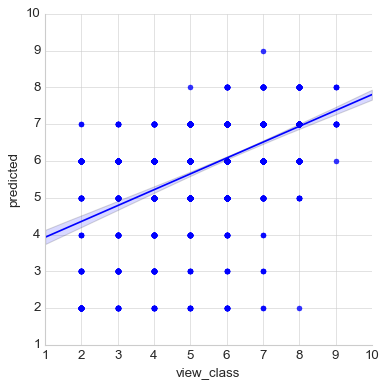

In [157]:
df_residuals = pd.DataFrame(y_test)
df_residuals['predicted'] = preds
df_residuals['residuals'] = df_residuals.predicted - df_residuals.view_class
sns.lmplot('view_class', 'predicted', data=df_residuals)

In [158]:
r2_score(df_residuals.view_class, df_residuals.predicted)


0.23393125202470566

In [34]:
df_big = df_main[df_main.viewCount > 100000000]
df_big_ss = ss.transform(df_big.loc[:, cols_include_initial])

df_big['predicted'] = 10**model.predict(df_big_ss)

#df_big.viewCount = df_big.viewCount.map(lambda x: '{:.6g}'.format(x))

df_big.loc[:, ['title', 'viewCount', 'predicted']].sort_values(by='viewCount', ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,title,viewCount,predicted
7479,Luis Fonsi - Despacito ft. Daddy Yankee,5555912002,1000000000
4268,Ed Sheeran - Shape of You [Official Video],3827104659,1000000000
7190,Wiz Khalifa - See You Again ft. Charlie Puth [...,3788737518,1000000000
5540,Mark Ronson - Uptown Funk ft. Bruno Mars,3256917992,1000000000
3634,PSY - GANGNAM STYLE(강남스타일) M/V,3218413082,1000000000
569,Justin Bieber - Sorry (PURPOSE : The Movement),3014897224,1000000000
7417,Maroon 5 - Sugar,2756205542,1000000000
7514,Taylor Swift - Shake It Off,2650920924,1000000000
5506,Katy Perry - Roar (Official),2638406673,1000000000
627,Enrique Iglesias - Bailando (Español) ft. Desc...,2582945265,100000000


## <a class="anchor" id="3.2-bullet">3.2 KClass binary</a>



In [159]:
y=1*(df_formodel.view_log>8)
X = df_formodel.loc[:, cols_include_initial]

X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=25)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [160]:
gb_bin = GradientBoostingClassifier()
gb_bin.fit(X_train_sc, y_train)
gb_bin.score(X_test_sc, y_test)

0.897721989772199

In [161]:
preds = gb_bin.predict_proba(X_test_sc)
print('    accuracy: ', gb_bin.score(X_test_sc, y_test), 'roc: ', roc_auc_score(y_test, [element[1] for element in preds]))

    accuracy:  0.897721989772199 roc:  0.8452105819288909


In [162]:
cm = confusion_matrix(y_test, gb_bin.predict(X_test_sc))
pd.DataFrame(cm)

,0,1
0,1912,25
1,195,19


In [146]:
df_main[df_main.view_log>8].shape

(900, 70)

## <a class="anchor" id="3.3-bullet">3.3 Neural Net</a>



In [45]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [46]:
y = df_formodel.view_class
X = df_formodel.loc[:, cols_include_initial]
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=30)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [47]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [61]:
model = Sequential()
#this does input and first activation
model.add(Dense(X_train_sc.shape[1], activation='relu', input_dim=X_train_sc.shape[1]))
model.add(Dropout(.5))
model.add(Dense(20, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(10, activation='relu'))

model.add(Dense(y_train_cat.shape[1], activation='softmax')) #1 neuron
model.compile(loss='categorical_crossentropy', optimizer='adam')

history = model.fit(X_train_sc, y_train_cat, validation_data=(X_test_sc, y_test_cat), epochs=100, verbose=0)
preds = model.predict(X_test_sc)
#print( 'score: ', r2_score(y_test, preds))

In [62]:
preds_cat = []
for i in range(len(preds)):
    preds_cat.append(list(preds[i]).index(max(preds[i])))

In [63]:
len(preds_cat)

2151

In [64]:
temp = pd.DataFrame([y_test]).T.reset_index().drop('index', axis=1)
temp['predicted'] = preds_cat

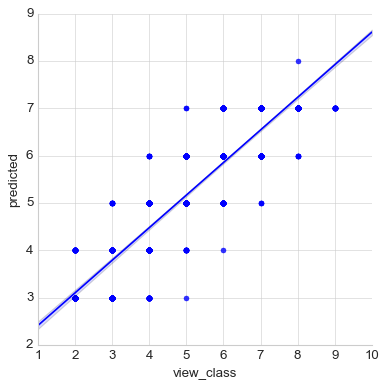

In [65]:
sns.lmplot('view_class', 'predicted', data=temp)

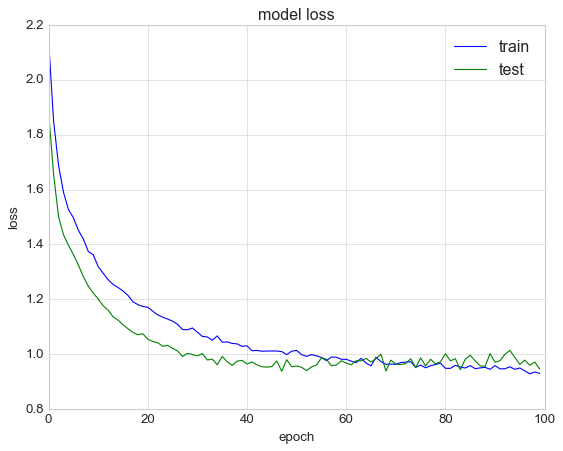

In [66]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

In [55]:
#Save point 1
#df_new.to_csv('./data/alphabet_pull_init_01.10.18.csv', index=False)

In [ ]:
#nope: AdaBoostRegressor, 

## <a class="anchor" id="3.2-bullet">3.2 Interpretation and Advanced Cleaning</a>


# <a class="anchor" id="4.0-bullet"> 4.0 Reference and Planning</a>